In [1]:
from bigraph_viz import plot_bigraph


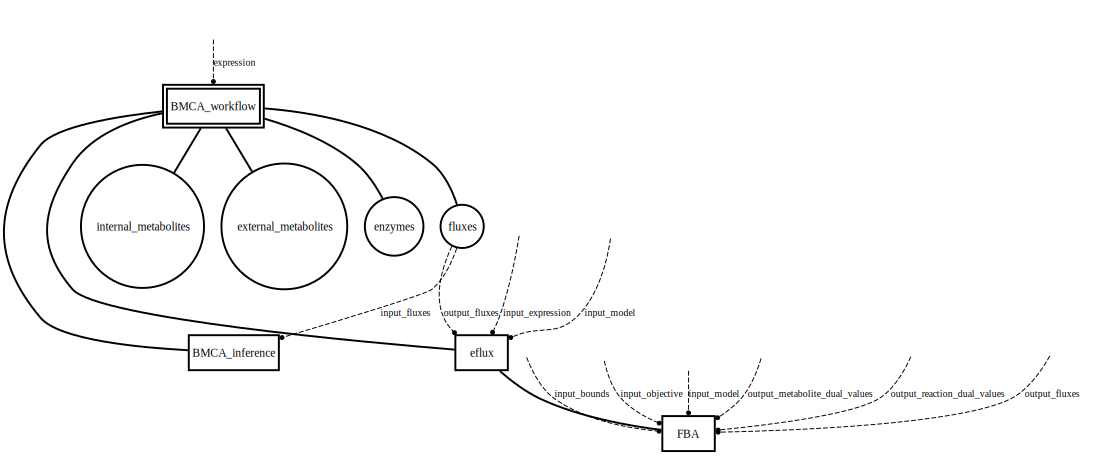

In [13]:
bounds_type = {
    'upper': 'float',
    'lower': 'float',
}

objective_type = 'function[array[(decisions),float],float]~string'

gene_type = 'string'
reaction_type = 'string'
metabolite_type = 'string'

perturbation_type = {
    'entity': 'reaction~gene',
    'direction': 'boolean',
}

medium_type = 'map[reaction,bounds]'

condition_type = '(medium|list[perturbation])'

spec = {
    'BMCA_workflow': {
        'fluxes': {},
        'internal_metabolites': {},
        'external_metabolites': {},
        'enzymes': {},
        
        '_ports': {
            'expression': 'map[array[(genes),float]]',
        },
        'BMCA_inference': {
            '_ports': {
                'input_fluxes': 'map[array[(reactions),float]]',
                'input_enzymes': 'map[array[(enzymes), float]]',
            },
            'wires': {
                'input_fluxes': ['fluxes'],
            },
        },
        'eflux': {
            '_ports': {
                'input_expression': 'map[array[(genes),float]]',
                'input_model': 'sbml',
                'output_fluxes': 'map[array[(reactions),float]]',
            },
            'config': {
                'condition_normalization': 'A',
                'scaling': 'media',
            },
            'FBA': {
                '_ports': {
                    'input_bounds': 'array[(reactions),bounds]',
                    'input_objective': 'objective',
                    'input_model': 'sbml',
                    'output_metabolite_dual_values': 'array[(metabolites),float]',
                    'output_reaction_dual_values': 'array[(reactions),float]',
                    'output_fluxes': 'array[(reactions),float]',
                },
            },
            'wires': {
                'output_fluxes': ['fluxes'],
            },
        },
    }
}

plot_bigraph(spec)